# Predicting Porosity

The example explains how to estimate porosity of a network. We also discuss some challenges in estimating the porosity of the network and how to reduce the estimation error.

In [9]:
import numpy as np
import openpnm as op
import porespy as ps
import matplotlib.pyplot as plt
ps.settings.tqdm["disable"] = True
op.visualization.set_mpl_style()
np.random.seed(10)
%matplotlib inline
np.set_printoptions(precision=5)

## Create a random cubic network

In [10]:
pn = op.network.Cubic(shape=[15, 15, 15], spacing=1e-6)
pn.add_model_collection(op.models.collections.geometry.cubes_and_cuboids)
pn.regenerate_models()

## Calculate void and bulk volume

In [11]:
Vol_void = np.sum(pn['pore.volume'])+np.sum(pn['throat.volume'])
inlet = pn.pores('left')
outlet = pn.pores('right')
A = op.topotools.get_domain_area(pn, inlets=inlet, outlets=outlet)
L = op.topotools.get_domain_length(pn, inlets=inlet, outlets=outlet)
Vol_bulk = A * L
Poro = Vol_void / Vol_bulk
print(f'The value of Porosity is: {Poro:.2f}')

[14:41:14] WARNING  Attempting to estimate inlet area...will be low        ]8;id=598820;file:///home/amin/Code/OpenPNM/openpnm/topotools/_topotools.py\_topotools.py]8;;\:]8;id=103125;file:///home/amin/Code/OpenPNM/openpnm/topotools/_topotools.py#1042\1042]8;;\

           WARNING  Attempting to estimate domain length...could be low if ]8;id=98825;file:///home/amin/Code/OpenPNM/openpnm/topotools/_topotools.py\_topotools.py]8;;\:]8;id=406584;file:///home/amin/Code/OpenPNM/openpnm/topotools/_topotools.py#1086\1086]8;;\
                    boundary pores were not added                                            

The value of Porosity is: 0.21


## Discussions and Issues

### Domain volume

One of the issues in estimation of porosity of the network is to estimate the domain volume correctly. In a cubic network for example, finding the length at x direction using Nx * spacing is erroneous. The reason is the domain length in x direction includes additional lengths from half of pore diameter for pores that locate on the left and right side. This is shown in figure below:

left) the green plane is located at the pore centers of left boundary pores and some pore volume on the left is ignored. Applying a similar plane on other sides of the network to find the length in each direction, the resulting bulk volume could be underestimated. 

right) the green plane is located at the far left side. Applying a similar plane on other sides of the network to find the length in each direction, the resulting bulk volume could be overestimated. 

![image](https://user-images.githubusercontent.com/43128873/187976526-d36c60be-8514-4326-8ee5-00a24ea90d56.png)

### Overlapping pores and throats

Another issue is to ensure that the pore-scale models for volume are consistent. For example there is no overlapping pores, because in this case the void volume calculation will overestimate the real void space. Depending on the pore scale model used for the shape of pores and throats, they may need special methods to calculate the void volume to account for the overlap between throats and pores. Depending on the method that was used for assigning throat lengths, this overlap volume may be included in volume calculations. Existing methods to correct the throat volumes are ``lens`` and ``pendular_ring`` methods available in geometry models for throat_volume. For example assuming a spheres and cylinders geometry, `lens` model in geometry collection tackles this problem. The `spheres_and_cylinders` geometry collection includes `throat.total_volume` and `throat.volume`. `throat.volume` is the volume of throat with corrections using ``lens`` volume:

Throat volume (`throat.volume`) = volume of cylinder (`throat.total volume`) - the overlap of cylinder with spherical pores at its two ends  (`difference`)

Let's create a spheres and cylinders geometry:

In [12]:
pn.add_model_collection(op.models.collections.geometry.spheres_and_cylinders)
pn.regenerate_models()

In [13]:
Vol_void_initial = np.sum(pn['pore.volume'])+np.sum(pn['throat.total_volume'])
Vol_void_corrected = np.sum(pn['pore.volume'])+np.sum(pn['throat.volume'])
Poro_initial = Vol_void_initial / Vol_bulk
Poro_corrected = Vol_void_corrected / Vol_bulk
print(f'Initial Porosity: {Poro_initial:.5f}')
print(f'Corrected Porosity: {Poro_corrected:.5f}')

Initial Porosity: 0.12852
Corrected Porosity: 0.12590


Although in this example the lens volume was negligible, depending on the size of the pores and throats, this value can be too high to be neglected.

.. Note:: <Pendular ring correction>

    `Pendular_ring` method calculates the volume of the pendular rings residing between the end of a cylindrical throat and spherical pores that are in contact but not overlapping. This volume should be added to the throat volume if the throat length was found as the center-to-center distance less the pore radii.

## Extracted networks

### Void volume

In extracted networks, different geometrical shapes can be assigned to the pores and throats and their volume can be calculated using existing geometry models. However, the original segmented pore regions are not regular shapes. Therefore, the total pore and throat volumes in the network don't add up to the known void volume, since the pores and throats don't fill space perfectly.

Porosity from image: 63.3%


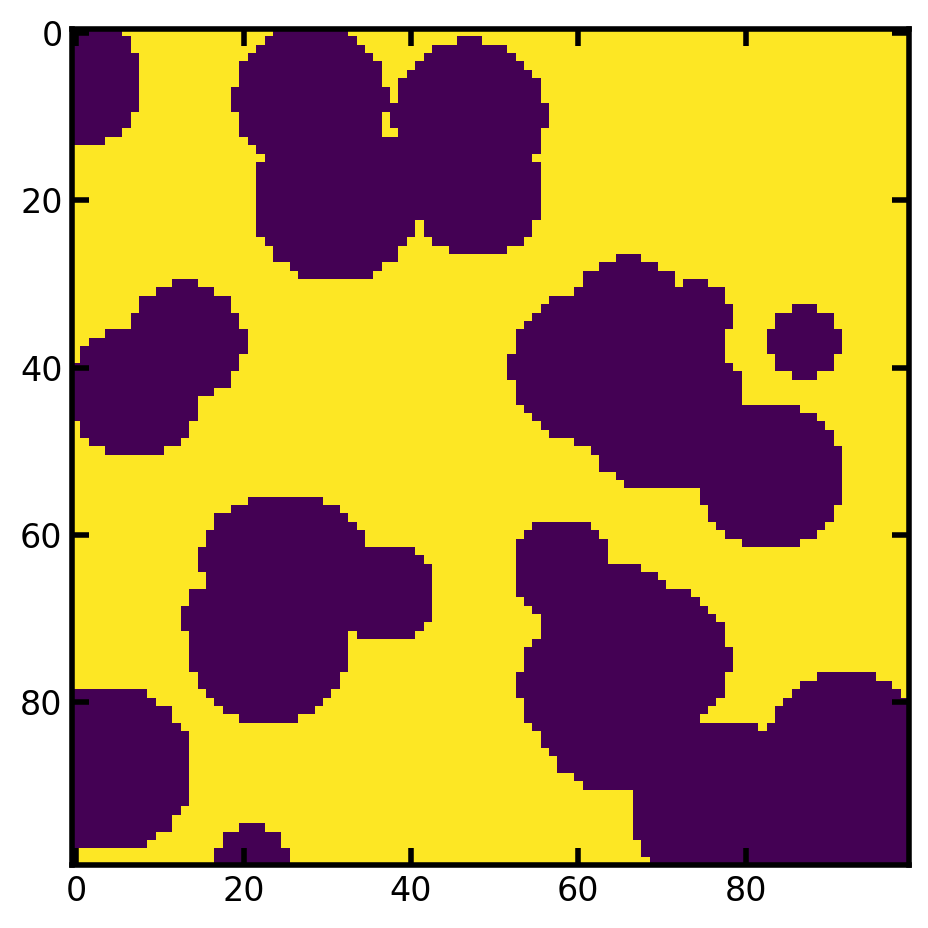

In [14]:
np.random.seed(10)
im = ps.generators.overlapping_spheres(shape=[100, 100, 100], r=10, porosity=0.5, maxiter=0)
plt.imshow(im[:, :, 50]);
im_poro = ps.metrics.porosity(im)
print(f"Porosity from image: {im_poro*100:.1f}%")

In [15]:
snow = ps.networks.snow2(im, boundary_width = 0)
network = snow.network
pn = op.io.network_from_porespy(network)
pn['pore.diameter']=network['pore.inscribed_diameter']
pn['throat.diameter']=network['throat.inscribed_diameter']
model=op.models.geometry.throat_length.cubes_and_cuboids
pn.add_model(propname='throat.length',
             model=model,
             regen_mode='normal')
model=op.models.geometry.pore_volume.cube
pn.add_model(propname='pore.volume',
             model=model,
             regen_mode='normal')
model=op.models.geometry.throat_volume.cuboid
pn.add_model(propname='throat.volume',
             model=model,
             regen_mode='normal')
pn.regenerate_models()

In [16]:
Vol_void = np.sum(pn['pore.volume'])+np.sum(pn['throat.volume'])
Vol_bulk = 100**3 # from the image
pnm_poro = Vol_void / Vol_bulk
print(f"Porosity from pnm: {pnm_poro*100:.1f}%")

Porosity from pnm: 67.5%


.. Notes:: <Volume errors>


    1) Note that in the example above, we assumed the original image was available for calculating the bulk volume. Assuming the original image is not available, calculating the bulk volume for the extracted network is another source of approximation error. Existing methods in topotools such as `get_domain_length` and `get_domain_area` tackle this problem to provide a better approximation of bulk volume of the network. 

    2) Note that in the example above, we assumed cubic pores and cuboid throats for the network. Assigning other diameters, shapes, and volume functions would result in a different estimation of void volume.